# **Part I: Clinical metadata analysis**

Your task in Part I is to explore the patients' metadata, learn to code with standard Python libraries, and get familiar with the Colab environment. The clinical data provides information about each patient’s demographics (age and sex) and each patient’s cognitive scores (MMSE and CDR). 

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics

In [3]:
# Set plotting style
%matplotlib inline
sns.set_theme(style="whitegrid")

In [4]:
# Load the clinical data
oasisDF = pd.read_csv('../OASIS_data.csv')

If the above command does not work, you can mount your Google Drive manually. Go to "Files" icon on the left of your notebook, and click on "Mount Drive" icon at the top to mount your Google Drive in the runtime's virtual machine. You need to upload the OASIS_data.csv file for Part 1 of the assignment. Scroll through your Google Drive in drop-down menu to the left of your notebook. In order to get the path to OASIS_data.csv, click on the three dots to the right of the file name and select "Copy path".

#### Question 1

We see below that that there were 377 patients conulted (rows), with 5 properties being assessed per patient (columns). Those are sex, age, CDR, MMS and diagnosis respectively. All patients have been assesed on all proporties, except for CDR. oasisDF.info() indicates only 197 non-null entries in the dataframe for this property, meaning that only 197 patients resulted in data for this property. The sex property is an object, which contains a character 'M'/'F' indicating the patient's sex. Similarly the diagnosis object contains the string "CN"/"AD" to indicate the patient is congitively normal or has altzheimer's disease respectively.

In [6]:

oasisDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sex        377 non-null    object 
 1   age        377 non-null    int64  
 2   CDR        197 non-null    float64
 3   MMS        377 non-null    float64
 4   diagnosis  377 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 14.9+ KB


In [6]:
oasisDF.head(10)

,sex,age,CDR,MMS,diagnosis
0,F,26,NaN,30.0,CN
1,M,35,NaN,30.0,CN
2,F,66,0.0,29.0,CN
3,M,78,1.0,23.0,AD
4,F,54,NaN,30.0,CN
5,M,21,NaN,30.0,CN
6,M,59,0.0,29.0,CN
7,M,81,0.0,28.0,CN
8,M,22,NaN,30.0,CN
9,M,48,NaN,30.0,CN


in the CDR column the NaN entries were substituted with a float 0, such that all values indices have a non-null value. 0 was chosen because there are no NaN fields that do not correspond with an MMS score of lower than 30. This means that all Patients who were not tested on the CDR scale had the most healty possible score on MMS, which means there were declared cognitively normal and hence testing on the CDR scale was not considered relevant. This means that we can assume they would also score maximally healthy on this metric. Hence the value of 0 was chosen.

In [7]:
for i in range(0,len(oasisDF.CDR)):
    if pd.isnull(oasisDF.CDR[i]):
        oasisDF.CDR = oasisDF.CDR.fillna(0)
oasisDF.head(10)

,sex,age,CDR,MMS,diagnosis
0,F,26,0.0,30.0,CN
1,M,35,0.0,30.0,CN
2,F,66,0.0,29.0,CN
3,M,78,1.0,23.0,AD
4,F,54,0.0,30.0,CN
5,M,21,0.0,30.0,CN
6,M,59,0.0,29.0,CN
7,M,81,0.0,28.0,CN
8,M,22,0.0,30.0,CN
9,M,48,0.0,30.0,CN


In [8]:
adDF = oasisDF.loc[oasisDF["diagnosis"] == "AD",["sex","age","CDR","MMS"]] # make subdataframe filtered for only AD patients
adDF.head(10)
# This dataframe adheres to to the indexing of the original dataframe. So index can still be used as patient ID.

,sex,age,CDR,MMS
3,M,78,1.0,23.0
12,F,69,1.0,21.0
16,F,71,1.0,27.0
21,M,64,0.5,22.0
26,F,75,0.5,26.0
27,F,73,0.5,26.0
41,M,70,0.5,26.0
47,M,81,0.5,26.0
53,F,83,0.5,18.0
57,M,82,0.5,27.0


We see below that there are relatively few people in the dataset that were diagnosed with AD. The number of people overall with AD in this dataset is 73 out of 377 (or roughly 19%). The ratio of AD:CN people in this set is roughly 1:4, meaning the data set is 'unbalanced' (i.e. the ratio of AD:CN is not close to 1:1).

It is said in the provided materials that women make up 2/3rd of the AD cases in general. However, it is important also note that the are also more female patients involved in this dataset. So looking at the absolute numbers is not appropriate. When we look at the relative prevelance of AD among men and women we see that about 19% of male patients have Ad, while this percentage is about 32% for female patients. 

This means that that in this dataset the ratio of women with Altzeheimer's is closer to 3/5 than 2/3. Causes of this might be that the sample size is to small to be representative of the real world. Another possibility is contamination of the sample set through biassed selection of the patients. This could be caused by the age distribution being too different for men and women, or because of uncontrollable actors. The U.S. Department of Health and Human Services suggests that, besides genetics, a [range of lifestyle factors](https://www.nia.nih.gov/health/what-causes-alzheimers-disease#factors), such as vascular condition, nutrition, exercises, and overall mental stimulation might have an impact on the development of altheimers's in people. Difference in lifestyle among men and women can be culturally influenced. So a vary localised sample group might skew the distribution among men and women on a broader scale.

Total patients with AD: 73/377 (or 19.36%)
Total female patients with AD: 46/235 (or 32.39%)  |  Total male patients with AD: 27/142 (or 19.01%)
Severe AD diagnosed for patient: 241  (M)
Severe AD diagnosed for patient: 371  (F)


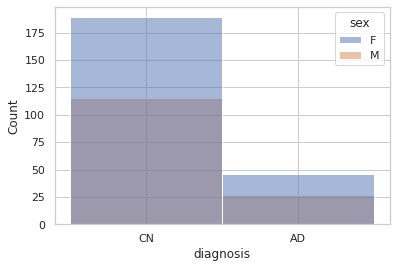

In [9]:

fAD = len(adDF[adDF["sex"] == "F"]) # number of female patients with AD
mAD = len(adDF[adDF["sex"] == "M"]) # number of male patients with AD
fCount = len(oasisDF[oasisDF["sex"]=="F"]) # number of female patients
mCount = len(oasisDF[oasisDF["sex"]=="M"]) # number of male patients

print("Total patients with AD: {:d}".format(len(adDF))+"/{:d} (or ".format(len(oasisDF))+"{:.2f}%)".format(len(adDF)/len(oasisDF)*100))
print("Total female patients with AD: {:d}".format(fAD)+"/{:d} (or ".format(fCount)+"{:.2f}%)".format(fAD/142*100)+"  |  Total male patients with AD: {:d}".format(mAD)+"/{:d} (or ".format(mCount)+"{:.2f}%".format(mAD/142*100)+")")

for i in range(0,377):
    if (oasisDF.MMS[i]<=10 or oasisDF.CDR[i]>=2) and oasisDF.diagnosis[i]=="AD":
        #SADid = np.append(SADid,i)
        print("Severe AD diagnosed for patient: "+str(i)+"  ("+oasisDF.sex[i]+")")

ax = sns.histplot(data=oasisDF, x="diagnosis" , hue="sex", discrete=True)



We see below that the distribution of men and women is unequal. There are little women in their 30's participating in this data, and much more women in under 30 than there are men. There are also significantly more women in their 70's and 80's and there are exclusively women in the range of 90+. Looking only at men there is also a disproprtionate amount of late teens/20-something year olds, just ike with women. With the men we see only few participants in their 50', while overall it appears the age distribution of men in this data set is more uniform than that of women.

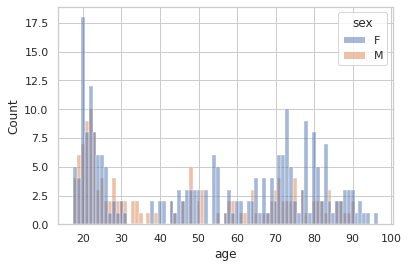

In [10]:
ax = sns.histplot(data=oasisDF, x="age" , hue="sex", discrete=True)


Morever, we see below that the youngest patients with AD is 63 years old. The majority of the younger population of this data set is female, meaning that the percentage of femalde AD patients in this set will likely be lower than in the real world. We can also see a decline in the participation rates of men as they age, while with women we see this increase after the age of 40.

So there are factors in play that could cause the disparity between male and female AD patients in this set to go either way. There is no clear indication which of these factors are dominant over the others and so there I won't attempt to speculate further on them, although it is useful to realise that these might have some affect on the prominence of AD between different classes of patients. So one ought to be careful when correllating the risk of AD with one of these classifications.

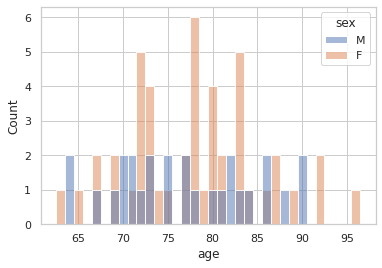

In [11]:
ax = sns.histplot(data=adDF, x="age" , hue="sex", discrete=True)

#### Question 2

In [12]:
# Split data into predictive features and class labels (diagnosis)
patients = oasisDF.drop(columns=['diagnosis'], inplace=False)
diags = oasisDF['diagnosis']

# Numeric encoding of categorical feature
# The "sex" information is no longer a string but an integer: 1 for male, 0 for female
encoder = LabelEncoder()
encoder.fit(['F','M'])
patients['sex'] = encoder.transform(patients['sex'])

# Visualize dataset
patients.head(10)

,sex,age,CDR,MMS
0,0,26,0.0,30.0
1,1,35,0.0,30.0
2,0,66,0.0,29.0
3,1,78,1.0,23.0
4,0,54,0.0,30.0
5,1,21,0.0,30.0
6,1,59,0.0,29.0
7,1,81,0.0,28.0
8,1,22,0.0,30.0
9,1,48,0.0,30.0


##### Question 2.1 | Patient Similarity and Clustering

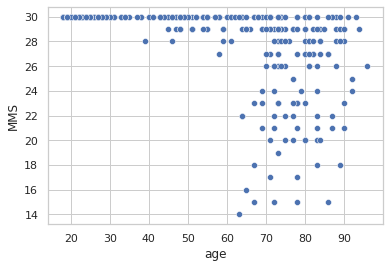

In [13]:
ax = sns.scatterplot(x=oasisDF["age"],y=oasisDF["MMS"])

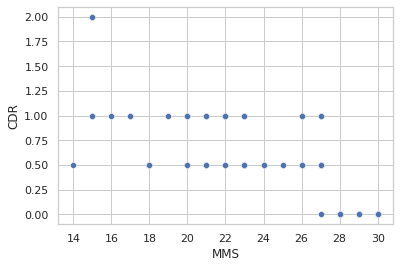

In [14]:
ax = sns.scatterplot(x=oasisDF["MMS"],y=oasisDF["CDR"])

377/377 correct clasifications | 100.00% succes rate.


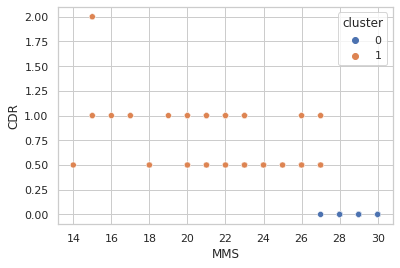

In [24]:
# Clustering with k-means
# Use the KMeans function from Sklearn to cluster X. The result of the clustering, which is a mapping of each patient to 
# one cluster, is referred to as the "labels" attribute in the Sklearn documentation.
#KMeans(n_clusters=8, *, init='k-mea=ns++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')

patientsNorm = StandardScaler(copy=True,with_std=True,with_mean=True).fit_transform(patients)
patientsNorm = pd.DataFrame(patientsNorm, index=patients.index, columns=patients.columns)

initCenters = np.array([[30,0],[25,0.4]])

kmeans = KMeans(n_clusters=2, init="k-means++", algorithm="full",n_init=100,max_iter=100).fit(patientsNorm[["MMS","CDR"]])
patients["cluster"] = kmeans.labels_ # CN corresponds to 0, AD to 1

succes = 0
for i in range(0,377):
    if ( patients["cluster"][i] == 0 and diags[i] == "CN") or (patients["cluster"][i] == 1 and diags[i] == "AD"):
        succes+=1

print(str(succes)+"/377 correct clasifications | {:.2f}%".format(succes/len(patients)*100)+" succes rate.")
kmeans.cluster_centers_

ax = sns.scatterplot(x="MMS",y="CDR",data=patients, hue="cluster")

In [ ]:
# Use a scatterplot plotting function from Seaborn (or any other type of figure) to study the output of the clustering and 
# answer the questions. 

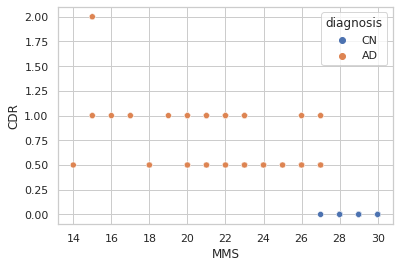

In [ ]:
ax = sns.scatterplot(x="MMS",y="CDR",data=oasisDF,hue="diagnosis")

#### Question 3

In [ ]:
# Label encoding of the classification target: Alzheimer's disease is labeled 1 and cognitively normal is labeled 0. 
# Alzheimer's disease (AD) is called the positive class because it is the class of interest. 
encoder = LabelEncoder()
encoder.fit(['CN','AD'])
y = encoder.transform(diags)

y[y==0] = 2
y[y==1] = 0
y[y==2] = 1

X = patients

In [ ]:
# Split X and y into a training set (75%) and a testing set (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
# Scale features (data matrix columns) to have a mean of zero and a standard deviation of one
# Scaling is necessary when features are measured in different units and have different ranges
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Instantiate a logistic regression model with L2 regularization
logreg_model = LogisticRegression(penalty='l2', random_state=0)

In [ ]:
# Fit the logistic regression model using the labeled training data
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
# Evaluate the model's predictive performance using the testing data
y_pred = logreg_model.predict(X_test)
print('Accuracy on testing set: ' + str(100*len(y_test == y_pred)/100) + '%')

# Confusion matrix on the testing set
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
true_negatives, false_positives, false_negatives, true_positives = confusion_matrix.ravel()
print(confusion_matrix)

Accuracy on testing set: 95.0%
[[80  0]
 [ 0 15]]


In [ ]:
# Inspect the logisitc regression model coefficients 
coef_sex = np.round(logreg_model.coef_[0][0], 3)
coef_age = np.round(logreg_model.coef_[0][1], 3)
coef_CDR = np.round(logreg_model.coef_[0][2], 3)
coef_MMS = np.round(logreg_model.coef_[0][3], 3)
print('Coefficient of sex: ' + str(coef_sex))
print('Coefficient of age: ' + str(coef_age))
print('Coefficient of CDR: ' + str(coef_CDR))
print('Coefficient of MMS: ' + str(coef_MMS))

Coefficient of sex: 0.117
Coefficient of age: 0.835
Coefficient of CDR: 2.922
Coefficient of MMS: -1.519
